In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as pyplotcolors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from scipy.sparse.linalg import svds
%matplotlib inline

In [2]:
import tools
reload(tools)
from tools import *

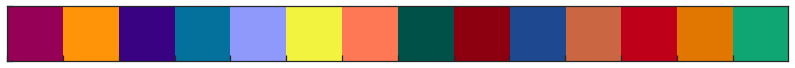

In [3]:
import seaborn as sns
import itertools
# plt.rc('text', usetex=True)
sns.set()
sns.set_style("white")
# sns.set(font_scale=1., 
#         rc={'text.usetex' : True,
#             'font.size' : 32})

sns.set(font_scale=1.8)
sty = sns.set_style("ticks",{"xtick.major.size":0.8,"ytick.major.size":0.8,
                             "xtick.direction": "in","ytick.direction": "in"})
# sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

# plt.rcParams.update({'mathtext.fontset' : 'stix'})
plt.rcParams.update({
    'font.family' : 'serif',
    'text.usetex' : True
    })
#     'legend.fontsize' : 10,
#     'font.size' : 11,
#     'axes.titlesize' : 11,
#     'axes.labelsize' : 11,

# Some more useful parameters at
#
# https://seaborn.pydata.org/tutorial/aesthetics.html
#
# Some colours:
# burgandy : (0.44655508845679537, 0.2211960285890096, 0.30515631911836943)

xkcdcolors = [
"dark magenta",
"tangerine",
"indigo",
"ocean blue",
"periwinkle blue",
"off yellow",
"melon",
"dark blue green",
"crimson",
"cobalt",
"terracotta",
"scarlet",
"pumpkin",
"bluish green",
"slate green",
"twilight blue",
"saffron",
"kiwi green"
]

npal = 14
shift = 0
stride = 1
start = 0
rot = 8.0
gamma = 1.0
dark = 0.1
light = 0.8
# palnamething = sns.cubehelix_palette(npal,start=start,rot=rot,light=light,dark=dark,reverse=True, gamma=gamma)
# palnamething = sns.color_palette("Paired")
# palnamething = sns.color_palette("bright")
palnamething = sns.color_palette(sns.xkcd_palette(xkcdcolors))

sns.set_palette(palnamething, npal)
pal = sns.color_palette(palnamething, npal)
palette = itertools.cycle(pal)
sns.palplot(pal)

for _ in range(shift):
    next(palette)
coldict = {}
for i in range(npal):
    for s in range(1,stride):
        next(palette)
    coldict.update({i:next(palette)})

In [4]:
# hyperparams
methods = ["random","WD","WA"]
nmethod = len(methods)
n_nbr = 36
run = "e3defect"

nfts = [1,1,1]
quad_dims=[[1,3],[2,4]]

source = "/home/walterms/mcmd/nn/data/pca/"
fnames = [source+"lat_nbrs_"+run+"_36_"+f for f in methods]

nfile = len(fnames)

In [5]:
fnames

['/home/walterms/mcmd/nn/data/pca/lat_nbrs_e3defect_36_random',
 '/home/walterms/mcmd/nn/data/pca/lat_nbrs_e3defect_36_WD',
 '/home/walterms/mcmd/nn/data/pca/lat_nbrs_e3defect_36_WA']

In [6]:
import tools
reload(tools)
from tools import *

with open(fnames[0]) as f:
    for li, l in enumerate(f):
        pass
nsample = li + 1

wx, wy = 0,1


Xset, Yset = {}, {}
scalers = {}
pca_set = {}
for fi,fname in enumerate(fnames):
    X = np.empty((nsample,n_nbr*nfts[fi]))
    with open(fname) as fin:
        for i, l in enumerate(fin):
            vals = [float(x) for x in l.split()] #l.split ignores the newline
            X[i] = vals

    s = StandardScaler()
    X = s.fit_transform(X)

    K = 10 # number reduced dimensions
    pca_ = PCA(n_components=K)
    Y = pca_.fit_transform(X)
    if methods[fi] == "WA":
        Y = quad_features(Y,quad_dims)
        K -= 2

    scalers.update({fi: s})
    pca_set.update({fi: pca_})
    Xset.update({fi: X})
    Yset.update({fi: Y})

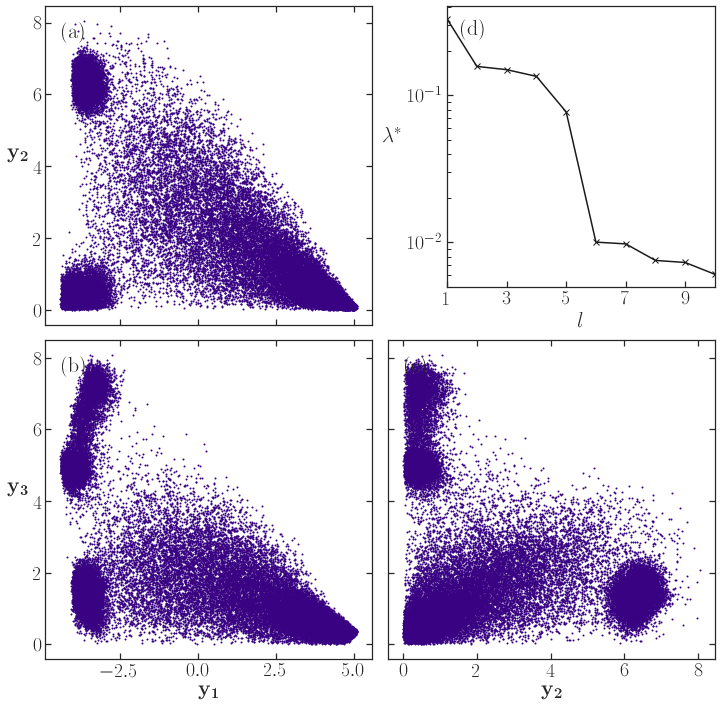

In [7]:
# For scatt and scattbda plots
fi = 2
name = "WA"

X_ = Xset[fi]
Y_ = Yset[fi]
pca_ = pca_set[fi]

mev = 5

fig = plt.figure(figsize=(12,12))
grid = plt.GridSpec(2,2,hspace=0.05, wspace=0.05,width_ratios=[1,1],height_ratios=[1,1])

gids = [[0,0],[1,0],[0,1],[1,1]]
texts = ["(a)","(b)","(d)","(c)"]
ws_ = [[0,1],[0,2],[-1,-1],[1,2]]

# For plotting along WD
plt_wdspine = False

if plt_wdspine:
    dws0 = np.linspace(-13,13,20)
    dws1 = np.array([-5.,-3.5,-2,-0.5,0,.5,1.5,2.5,4,2.5,1.5,1,0,-1,-2,-3,-2,-1,0,1,2,3,4])
    dws2 = np.sin(twopi*np.linspace(-1,1,20))*3.5
    cols = [(0.8,0.8,1.0*h) for h in np.linspace(0,1,20)]

for p in range(4):
    if p == 2:
        scatt = fig.add_subplot(grid[gids[p][0],gids[p][1]])
        pos = scatt.get_position()
        scatt.set_position([0.59,0.555,pos.x1-0.59,pos.y1-0.555])
        scatt.semilogy(np.arange(1,11),pca_.explained_variance_ratio_,'x-',c='k')
#         scatt.set_ylim(0.007,1)
        scatt.set_xlim(1,10)
        _=scatt.set_xticks(np.arange(1,11,2))
        scatt.set_xlabel(r'$l$')
        scatt.set_ylabel(r'$\lambda^*$',rotation="horizontal",labelpad=15)
    else:
        scatt = fig.add_subplot(grid[gids[p][0],gids[p][1]])
        _ = scatt.scatter(Y_[::mev, ws_[p][0]], Y_[::mev, ws_[p][1]],s=1,c=coldict[2],rasterized=True)
        if p == 0:
            scatt.set_ylabel(r'$\mathbf{y_2}$',rotation="horizontal",labelpad=15)
#             scatt.set_xticks([])
            scatt.tick_params(labelbottom=False,top="on",right="on")
            if plt_wdspine:
                scatt.scatter(dws0,dws1,s=60,c=cols,edgecolors='k',linewidths=1.5)
        if p == 1:
            scatt.set_ylabel(r'$\mathbf{y_3}$',rotation="horizontal",labelpad=15)
            scatt.set_xlabel(r'$\mathbf{y_1}$')
            scatt.tick_params(top="on",right="on")
            if plt_wdspine:
                scatt.scatter(dws0,dws2,s=60,c=cols,edgecolors='k',linewidths=1.5)
        if p == 3:
            scatt.set_xlabel(r'$\mathbf{y_2}$')
#             scatt.set_yticks([])
            scatt.tick_params(labelleft="off",left=1,top=1,right=1)
            if plt_wdspine:
                scatt.scatter(dws1,dws2,s=60,c=cols,edgecolors='k',linewidths=1.5)
    scatt.text(0.05,0.9,texts[p],
        horizontalalignment="left",
        transform=scatt.transAxes)
    
    

    

In [35]:
savedir = "/home/walterms/mcmd/imgs/paperimgs/"
savename = savedir+"pca_multiscatt_"+name+"_raster"
ans = raw_input("You want to save "+savename+"?")
if ans != "no":
    print "Saving file"
#     f.savefig(savename+".eps",pad_inches=0)
    fig.savefig(savename+".eps",bbox_inches='tight',dpi="figure")    
    fig.savefig(savename+".pdf",bbox_inches='tight',dpi="figure")

You want to save /home/walterms/mcmd/imgs/paperimgs/pca_multiscatt_random_raster?
Saving file


Text(0.5,0,u'neighbour')

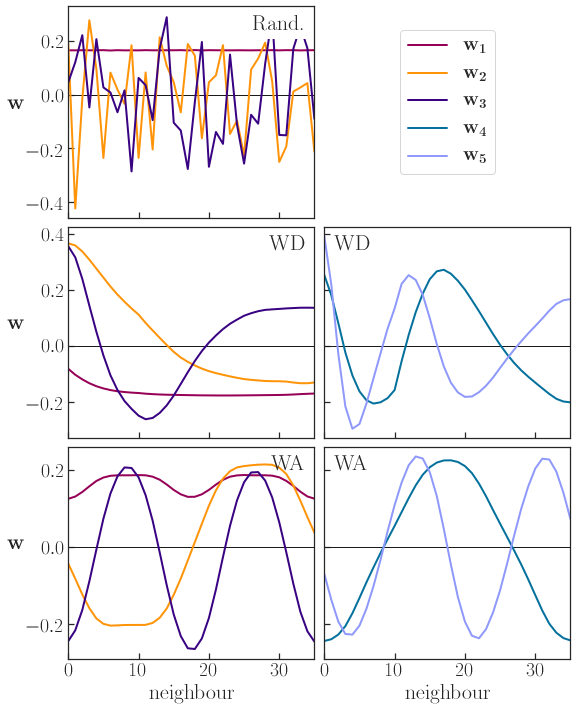

In [8]:
fig = plt.figure(figsize=(9,12))
grid = plt.GridSpec(3,2, wspace=0.04, hspace=0.04)
lw = 2.0

ax00 = fig.add_subplot(grid[0,0])
ax10 = fig.add_subplot(grid[1,0])
ax11 = fig.add_subplot(grid[1,1],sharey=ax10)
ax20 = fig.add_subplot(grid[2,0])
ax21 = fig.add_subplot(grid[2,1],sharey=ax20)

all_axes = fig.get_axes()

for ax in all_axes:
    plotLine(0,0.,35,0.,c='k',lw=1.0,ax=ax)
    ax.set_xlim(0,35)

# Random plot
pca_ = pca_set[0]
ws_ = pca_.components_[:3]
for i, w_i in enumerate(ws_):
    ax00.plot(w_i,label=r'$\mathbf{w_%d}$'%(i+1), color=coldict[i],linewidth=lw)
ax00.set_ylabel(r'$\mathbf{w}$',rotation="horizontal",labelpad=10)
ax00.tick_params(labelbottom=0)
ax00.text(0.96,0.96,"Rand.",
          horizontalalignment="right",
          verticalalignment="top",transform=ax00.transAxes,
         bbox={"facecolor":"white"})
    
# Other two rows
names = ["WD","WA"]
for ia in [1,2]:
    pca_ = pca_set[ia]
    ws_ = pca_.components_[:5]

    ax = all_axes[ia*2 - 1]
    # Plot first 3 eigs
    for i, w_i in enumerate(ws_[:3]):
        ax.plot(w_i,label=r'$\mathbf{w_%d}$'%(i+1), color=coldict[i],linewidth=lw)
    ax.set_ylabel(r'$\mathbf{w}$',rotation="horizontal",labelpad=10)
    if ia == 1:
        ax.tick_params(labelbottom=0)

    ax.text(0.96,0.96,names[ia-1],
          horizontalalignment="right",
          verticalalignment="top",transform=ax.transAxes)
#          bbox={"facecolor":"white"})
        
        
    ax = fig.axes[ia*2]
    for w_i in ws_[3:]:
        i+=1
        ax.plot(w_i,label=r'$\mathbf{w_%d}$'%(i+1), color=coldict[i],linewidth=lw)

    ax.tick_params(labelleft=0)
    ax.text(0.04,0.96,names[ia-1],
          horizontalalignment="left",
          verticalalignment="top",transform=ax.transAxes)
#          bbox={"facecolor":"white"})

    if ia == 1:
        ax.tick_params(labelbottom=0)
        h0, l0 = ax10.get_legend_handles_labels()
        h1, l1 = ax11.get_legend_handles_labels()
        ax.legend(h0+h1,l0+l1,loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=1,
                    markerscale=0.5,columnspacing=1.0)


        
ax20.set_xlabel(r'neighbour')
ax21.set_xlabel(r'neighbour')

In [88]:
savedir = "/home/walterms/mcmd/imgs/paperimgs/"
savename = savedir+"eigvecs_all"
ans = raw_input("You want to save "+savename+"?")
if ans != "no":
    print "Saving file"
#     f.savefig(savename+".eps",pad_inches=0)
    fig.savefig(savename+".eps",bbox_inches='tight',dpi="figure")

You want to save /home/walterms/mcmd/imgs/paperimgs/eigvecs_all?
Saving file


In [ ]:
samp = pca.transform(nbrs[1].reshape(1,-1))
construct = np.dot(samp,pca.components_)[0]
pca_inv = pca.inverse_transform(samp[0])
plt.plot(nbrs[1])
plt.plot(pca_inv)
plt.plot(construct)

In [ ]:
# If you want to do inverse stuff
# For sigdim higher than 2, have to use means of higher dimensions
# It turns out that the transform preserves the 0 means so just use 0
fi = 1
name = "WD"

X_ = Xset[fi]
Y_ = Yset[fi]
pca_ = pca_set[fi]
s_ = scalars[f]

mev = 2

fig = plt.figure(figsize=(12,12))
grid = plt.GridSpec(2,2,hspace=0.05, wspace=0.05,width_ratios=[1,1],height_ratios=[1,1])


f,ax = plt.subplots(1,2,figsize=(12,4))
test = np.zeros((K))
test[:3] = [0,0,1]
test = samp.reshape(10)
if use_quadrature:
    print "You can't pca inverse the quad features"
else:
    test_nbrs = pca.inverse_transform(test)
    if use_scaling:
        test_nbrs = S.inverse_transform(test_nbrs)
    # test_nbrs_trans = S.transform(test_nbrs.reshape(1,-1))
    ax[0].plot(test_nbrs,c="k")
    # ax[0].set_ylim(-1,1)

wi = 1
# ax[1].plot(test_nbrs_trans[0])
# Q = np.array([np.dot(test_nbrs_trans,ww) for ww in ws])
# print Q

In [34]:
# Colouring method
#
use_kmeans = False
use_dims = False # color by first 3 dims
use_1D = True
Dim = 0 # 0 is first dim

avg for plusone with random mode is -1.33 (standardized). 
avg for ws\_0 analogue is -0.16666.  
SS.mean\_ approx 0.65 for all nbrs. 
SS.var\_ approx 0.22

In [43]:
methods[2] == "WA"

True

In [52]:
# Plot the four defect pca response curves
nblskip = 1
nsnap = 10
pca_feat_dict, means, stds = {}, {}, {}

for fi in range(nmethod):
    k = 10
    quads = None
    if methods[fi] == "WA":
        quads = quad_dims
        k = 10-len(quad_dims)
    pca_feat_arr = np.zeros((4,nsnap,k))
    means_, stds_ = np.zeros((4,k)), np.zeros((4,k))
    for i_def in range(4):
        pca_feats, features_raw, features, test_nbrs, alph = get_defect(defect_files[i_def],fi,
                                                                        nblskip=nblskip,nsnap=nsnap,quad_dims=quads)
        pca_feat_arr[i_def] = pca_feats

        means_[i_def] = np.mean(pca_feats,axis=0)
        stds_[i_def] = np.std(pca_feats,axis=0)
        
    means.update({methods[fi]: means_})
    stds.update({methods[fi]: stds_})

Text(0.5,0,u'$l$')

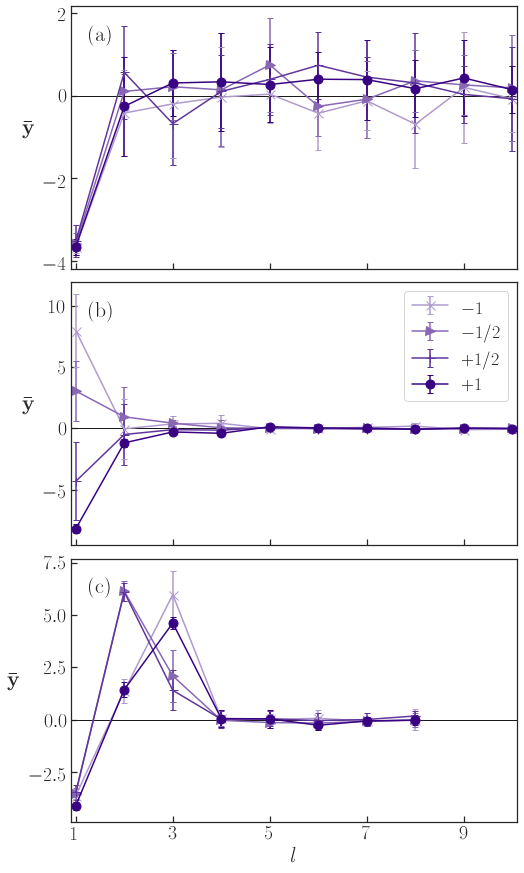

In [67]:
fig,ax = plt.subplots(3,1,figsize=(8,15),gridspec_kw={"hspace":0.05})
markers=["x",">","+","o"]
labels=[r"$-1$",r"$-1/2$",r"$+1/2$",r"$+1$"]
texts = ["(a)","(b)","(c)"]

Ks = [10,10,8]
K = 10
for fi,method in enumerate(methods):
    for i_def in range(4):
        col = tuple([cc + 0.8*(1-cc) * (0.75 - i_def/4.) for cc in coldict[2]])
        ax[fi].errorbar(np.arange(1,Ks[fi]+1),means[method][i_def],yerr=stds[method][i_def],fmt='-',capsize=3,
                    marker=markers[i_def],mfc=None,c=col,markersize=9,label=labels[i_def])

    plotLine(-0.1,0,K+0.1,0,c='k',ax=ax[fi],lw=1.0)
    ax[fi].set_xlim(0.9,K+0.1)
    # ax[fi].set_ylim(-10,10)
    ax[fi].set_ylabel(r'$\mathbf{\bar{y}}$',rotation="horizontal",labelpad=15)
    _=ax[fi].set_xticks(np.arange(1,K+1,2))
    
    if fi != 2:
        ax[fi].tick_params(labelbottom="off")
    if fi == 1:
        def_legend = ax[fi].legend(fontsize="small",loc="best")
        
    ax[fi].text(0.04,0.93,texts[fi],
          horizontalalignment="left",
          verticalalignment="top",transform=ax[fi].transAxes)

ax[-1].set_xlabel(r'$l$')

In [68]:
savedir = "/home/walterms/mcmd/imgs/paperimgs/"
savename = savedir+"multi_response_curve"
ans = raw_input("You want to save "+savename+"?")
if ans != "no":
    print "Saving file"
#     f.savefig(savename+".eps",pad_inches=0)
    fig.savefig(savename+".eps",bbox_inches='tight',dpi="figure")

You want to save /home/walterms/mcmd/imgs/paperimgs/multi_response_curve?
Saving file


In [79]:
# Plot the four defect pca response curves
edges = [7.00,14.00]
iprobes = [210,210] #10,10 looks good for isotrop
nblskip = 1
nsnap = 50
nprobe = 16

IN_pca_feat_dict, IN_means, IN_stds = {}, {}, {}


for fi, method in enumerate(methods):

    k = 10
    quads = None
    if method == "WA":
        quads = quad_dims
        k = 10-len(quad_dims)

    pca_feats = np.zeros((2,nsnap*nprobe,k))
    means = np.zeros((2,k))
    stds = np.zeros((2,k))
        
    for k in [0,1]:
        pca_feats_, features_raw, features, test_nbrs, alph = get_IN(edges[k], nblskip, fi,quad_dims=quads,
                                                             iprobe=iprobes[k],nsnap=nsnap,nprobe=nprobe)

        pca_feats[k] = pca_feats_
        means[k] = np.mean(pca_feats[k],axis=0)
        stds[k] = np.std(pca_feats[k],axis=0)
        
    IN_pca_feat_dict.update({method: pca_feats})
    IN_means.update({method: means})
    IN_stds.update({method: stds})

Text(0.5,0,u'$l$')

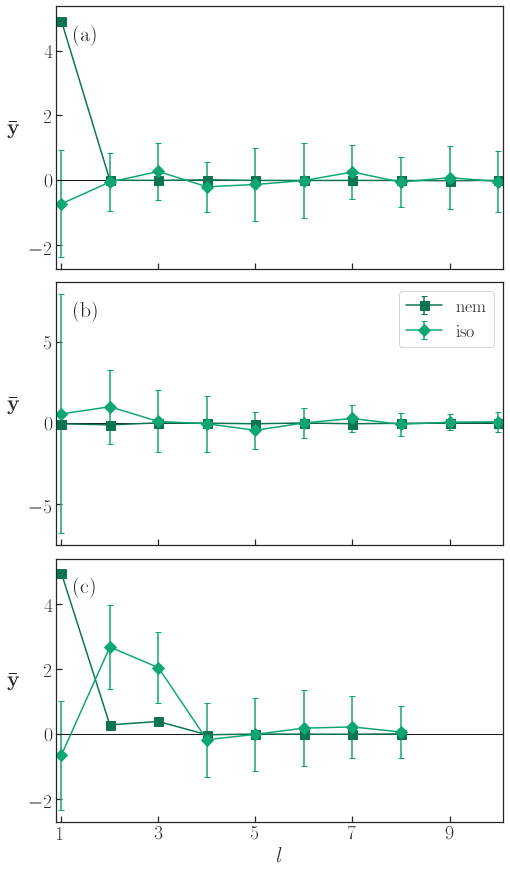

In [81]:
fig,ax = plt.subplots(3,1,figsize=(8,15),gridspec_kw={"hspace":0.05})
IN_markers=["s","D"]
IN_labels=[r'nem',r'iso']
texts = ["(a)","(b)","(c)"]

c = np.array(coldict[13])
IN_cols = [c*0.7, c]
Ks = [10,10,8]
K = 10

for fi,method in enumerate(methods):
    for j in range(2):
        ax[fi].errorbar(np.arange(1,Ks[fi]+1),IN_means[method][j],yerr=IN_stds[method][j],fmt='-',capsize=3,
                    marker=IN_markers[j],mfc=None,c=IN_cols[j],markersize=9,label=IN_labels[j])

    plotLine(-0.1,0,K+0.1,0,c='k',ax=ax[fi],lw=1.0)
    ax[fi].set_xlim(0.9,K+0.1)
    # ax[fi].set_ylim(-10,10)
    ax[fi].set_ylabel(r'$\mathbf{\bar{y}}$',rotation="horizontal",labelpad=15)
    _=ax[fi].set_xticks(np.arange(1,K+1,2))
    
    if fi != 2:
        ax[fi].tick_params(labelbottom="off")
    if fi == 1:
        def_legend = ax[fi].legend(fontsize="small",loc="best")
        
    ax[fi].text(0.04,0.93,texts[fi],
          horizontalalignment="left",
          verticalalignment="top",transform=ax[fi].transAxes)

ax[-1].set_xlabel(r'$l$')

In [82]:
savedir = "/home/walterms/mcmd/imgs/paperimgs/"
savename = savedir+"IN_multi_response_curve"
ans = raw_input("You want to save "+savename+"?")
if ans != "no":
    print "Saving file"
#     f.savefig(savename+".eps",pad_inches=0)
    fig.savefig(savename+".eps",bbox_inches='tight',dpi="figure")

You want to save /home/walterms/mcmd/imgs/paperimgs/IN_multi_response_curve?
Saving file


In [78]:
import tools
reload(tools)
from tools import *

def get_int_probes(probes):
    nx = int(np.sqrt(probes.shape[0]))
    # Grab 16 probes from middle
    r3 = 2 # root / 2 of patch
    ips = []
    for ix in range(nx//2 - r3,nx//2 + r3):
        for iy in range(nx//2 - r3, nx//2 + r3):
            ips.append(nx*iy + ix)
    return probes[np.asarray(ips),:]
    
    

def get_IN(edge,nblskip,fi,nsnap=1,nprobe=1,iprobe=None,quad_dims=None):
    
    method = methods[fi]
    SS = scalers[fi]
    pca = pca_set[fi]
    
    k = 10
    if quad_dims:
        k = 10-len(quad_dims)

    # nsnap is how many to grab
    run = "edge_3_"+"%0.2f"%(edge)
    fname = "/home/walterms/mcmd/nn/data/unlbl/"+run
    globaledge = edge
    nrod = 28**2
    L = 1.0
    nx = 20
    probes = gen_probes(nx, edge)
    # Grab nprobes from the interior
    
    if iprobe:
        probes = probes[iprobe].reshape(1,2)
    else:
        probes = get_int_probes(probes)
    nbl = 0

    if nblskip == -1:
        # Count number of blocks
        with open(fname) as fin:
            for i, l in enumerate(fin):
                if l == "\n":
                    nbl += 1
        nblskip = nbl - 1

    rho = nrod / (edge*edge)
#     print "rho ",rho
    rods = np.empty(shape=(nrod,3))
    nbl = 0
    irod = 0

    pca_feats = np.zeros((nsnap*nprobe,k))
    isnap = 0
    with open(fname) as fin:
        for i, l in enumerate(fin):
            if nbl < nblskip:
                if l == "\n":
                    nbl += 1
                continue
            if l == "\n":
                # Done block
                # Transform into higher nbr dimension
                features, nbr_coords_full, alphas = get_lat_nbrs(rods,n_nbr,edge,nx,probes,method=method,ret_nbrs=True)
                features_raw = features.copy()
                features = SS.transform(features) # standardize from training set

                pca_feats_ = pca.transform(features) # reduce dimensions with pca
                if quad_dims:
                    pca_feats_ = quad_features(pca_feats_,quad_dims)
                pca_feats[isnap*nprobe:nprobe*(isnap+1)] = pca_feats_
                isnap+=1
                rods = np.empty(shape=(nrod,3))
                irod = 0
                nbl += 1
                if nbl == nsnap+nblskip: break
                else: continue

            if l.startswith("label"): continue
            rod = [float(x) for x in l.split()]
            rods[irod] = [globaledge*rod[0], globaledge*rod[1], myrotate(twopi*rod[2])]
            irod += 1

    return pca_feats, features_raw, features, nbr_coords_full, alphas

In [51]:
import tools
reload(tools)
from tools import *

defect_files = ["minusone_small","minushalf_small","plushalf_small","plusone_small"]

def get_defect(defname, fi, nblskip=0, nsnap=1, quad_dims=None):
    
    method = methods[fi]
    SS = scalers[fi]
    pca = pca_set[fi]
    
    k = 10
    if quad_dims:
        k = 10-len(quad_dims)
        
    edge = 3.
    fname = "/home/walterms/mcmd/nn/data/defects/"+defname
    globaledge = 5.
    nrod = 6**2
    
    nx = 20
    probes = gen_probes(nx, globaledge)
    probes = probes[190].reshape(1,2)
    
    L = 1.0
    NBL = 1

    rods = np.empty(shape=(nrod,3))
    nbl = 0
    irod = 0

    pca_feats = np.zeros((nsnap,k))
    isnap = 0
    with open(fname) as fin:
        for i, l in enumerate(fin):
            if nbl < nblskip:
                if l == "\n":
                    nbl += 1
                continue
            if l == "\n":
                # Done block
                # Transform into higher nbr dimension
                features, nbr_coords_full, alphas = get_lat_nbrs(rods,n_nbr,edge,nx,probes,
                                                                 method=method,ret_nbrs=True)
                features_raw = features.copy()
                features = SS.transform(features) # standardize from training set

                pca_feats_ = pca.transform(features) # reduce dimensions with pca
                if quad_dims:
                    pca_feats_ = quad_features(pca_feats_,quad_dims)
                pca_feats[isnap] = pca_feats_
                isnap+=1
                rods = np.empty(shape=(nrod,3))
                irod = 0
                nbl += 1
                if nbl == nsnap+nblskip: break
                else: continue

            if l.startswith("label"): continue
            rod = [float(x) for x in l.split()]
            rods[irod] = [globaledge*rod[0], globaledge*rod[1], myrotate(twopi*rod[2])]
            irod += 1
        
    return pca_feats, features_raw[0], features[0], nbr_coords_full[0], alphas[0]